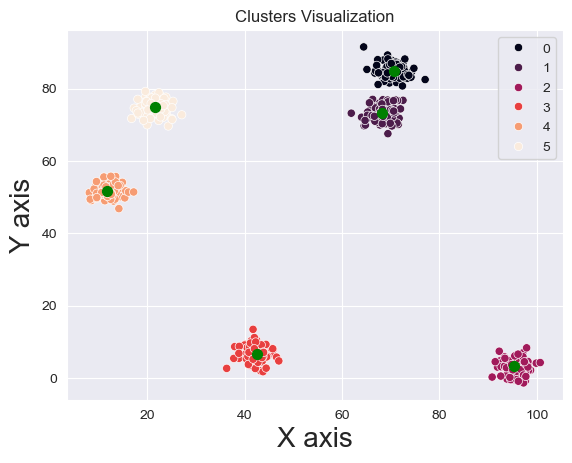

In [257]:

from mysrc.WishartClusterizationAlgorithm import Wishart
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.datasets import make_blobs
# import matplotlib as plt
import seaborn as sns

X, y, centers = make_blobs(n_samples=500, centers=6, n_features=2, cluster_std=2, center_box=(2, 100), shuffle=True,
                           return_centers=True, random_state=666)
X = pd.DataFrame(data=X, columns=["x", "y"])

plt.rc('axes', labelsize=20)
sns.scatterplot(data=X, x='x', y='y', hue=y, palette='rocket')
plt.scatter(centers[:, 0], centers[:, 1], s=50, c='g', marker='o')
plt.title('Clusters Visualization')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.legend()
plt.show()


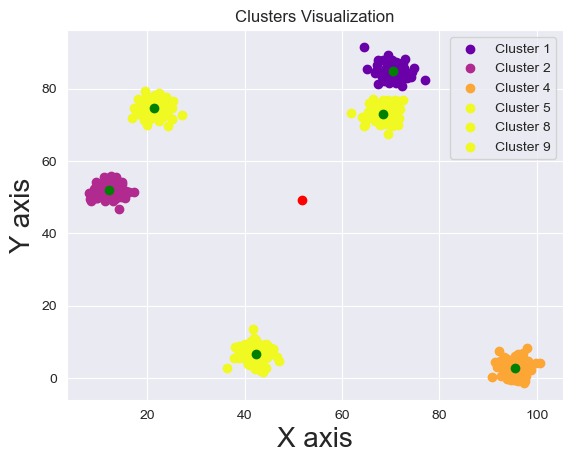

In [263]:

wishart = Wishart(k=12, mu=0.01)
x_list = X.values.tolist()
wishart.fit(x_list)
clusters = wishart.labels_
cluster_centers = wishart.clusters_centers_
from matplotlib import colormaps

c = list(wishart.center)
unique_clusters = set(clusters)
colors = plt.get_cmap('plasma', len(unique_clusters))
for cluster in unique_clusters:
    cluster_points = X[clusters == cluster]
    plt.scatter(cluster_points['x'], cluster_points['y'],
                color=colors(cluster), label=f'Cluster {cluster}')
    plt.scatter(cluster_centers[cluster][0], cluster_centers[cluster][1], color='green')
plt.scatter(c[0], c[1], color='red')
plt.title('Clusters Visualization')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.legend()
plt.show()

In [259]:
import numpy as np
from numpy.linalg import norm


def calc_RMSSTD(wishart_: Wishart):
    clusters, clusters_centers = wishart_.clusters_, wishart_.clusters_centers_
    cluster_labels, cluster_sizes = np.unique(wishart_.labels_[wishart_.labels_ > 0], return_counts=True)
    sum = 0
    for i in cluster_labels:
        for node in clusters[i]:
            sum += norm((node - clusters_centers[i])) ** 2
    divisor = 1 / len(cluster_labels)
    temp = 0
    for i in cluster_labels:
        temp += len(clusters[i]) - 1
    divisor /= temp
    return (sum * divisor) ** 0.5


def calc_R_squared(wishart_: Wishart):
    clusters_, clusters_centers = wishart_.clusters_, wishart_.clusters_centers_
    cluster_labels, cluster_sizes = np.unique(wishart_.labels_[wishart_.labels_ > 0], return_counts=True)
    c = wishart_.center
    sum = 0
    for i in cluster_labels:
        for node in clusters_[i]:
            sum += norm((node - c)) ** 2 - norm((node - clusters_centers[i])) ** 2
    divisor = 0
    for i in cluster_labels:
        for node in clusters_[i]:
            divisor += norm((node - c)) ** 2
    return sum / divisor


def calc_Modified_Hubert_statistic(wishart_: Wishart):
    #короче хрен эту метрику посчитаешь
    clusters_, clusters_centers = wishart_.clusters_, wishart_.clusters_centers_
    cluster_labels, cluster_sizes = np.unique(wishart_.labels_[wishart_.labels_ > 0], return_counts=True)
    c = wishart_.center
    n = len(cluster_labels)
    sum = 0
    for i in cluster_labels:
        for j in cluster_labels:
            for x in clusters_[i]:
                for y in clusters_[j]:
                    for ci in clusters_[i]:
                        for cj in clusters_[j]:
                            sum += norm(x - y) * norm(ci - cj)
    return sum * 2 / n / (n - 1)


def calc_Calinski_Harabasz_index(wishart_: Wishart):
    clusters_, clusters_centers = wishart_.clusters_, wishart_.clusters_centers_
    cluster_labels, cluster_sizes = np.unique(wishart_.labels_[wishart_.labels_ > 0], return_counts=True)
    c = wishart_.center
    n = len(wishart.labels_)
    nc = len(cluster_sizes)
    sum = 0
    for i in cluster_labels:
        sum += len(clusters_[i]) * norm(clusters_centers[i] - c) ** 2
    sum /= (nc - 1)
    div = 0
    for i in cluster_labels:
        for node in clusters_[i]:
            div += norm(clusters_centers[i] - node) ** 2
    div /= (n - nc)
    return sum / div


def calc_I_index(wishart_: Wishart):
    clusters_, clusters_centers = wishart_.clusters_, wishart_.clusters_centers_
    cluster_labels, cluster_sizes = np.unique(wishart_.labels_[wishart_.labels_ > 0], return_counts=True)
    c = wishart_.center
    n = len(cluster_labels)
    nc = len(cluster_sizes)
    sum = 0
    for i in cluster_labels:
        sum += norm(clusters_centers[i] - c) ** 2
    sum /= nc
    div = 0
    for i in cluster_labels:
        for node in clusters_[i]:
            div += norm(clusters_centers[i] - node)
    sum /= div
    a = []
    for i in cluster_labels:
        for j in cluster_labels:
            a.append(norm(clusters_centers[i] - clusters_centers[j]))
    sum *= max(a)
    return sum


def calc_DUNNS_indices(wishart_: Wishart):
    clusters_, clusters_centers = wishart_.clusters_, wishart_.clusters_centers_
    cluster_labels, cluster_sizes = np.unique(wishart_.labels_[wishart_.labels_ > 0], return_counts=True)
    c = wishart_.center
    n = len(cluster_labels)
    nc = len(cluster_sizes)
    a = []
    for i in cluster_labels:
        for j in cluster_labels:
            if i != j:
                for x in clusters_[i]:
                    for y in clusters_[j]:
                        a.append(norm(x - y))
    #minx∈Ci,y∈Cj d(x,y)
    minx = min(a)
    #maxk{maxx,y∈Ck d(x,y)}
    a = []
    for i in cluster_labels:
        for x in clusters_[i]:
            for y in clusters_[i]:
                a.append(norm(x - y))
    maxx = max(a)
    return minx / maxx


def ax(x, cluster_):
    a = 0
    for j in cluster_:
        a += norm(x - j)
    if len(cluster_) == 1:
        return 0
    return a / (len(cluster_) - 1)


def bx(x, i, cluster_, clusters_):
    b = []
    for j in clusters_.keys():
        a = 0
        if i != j:
            for y in clusters_[j]:
                a += norm(x - y)
            a /= (len(clusters_[j]))
            b.append(a)
    return min(b)


def Silhoette_index(wishart_: Wishart):
    clusters_, clusters_centers = wishart_.clusters_, wishart_.clusters_centers_
    cluster_labels, cluster_sizes = np.unique(wishart_.labels_[wishart_.labels_ > 0], return_counts=True)
    c = wishart_.center
    n = len(cluster_labels)
    nc = len(cluster_sizes)
    b = 0
    for i in cluster_labels:
        ni = len(clusters_[i])
        a = 0
        for x in clusters_[i]:
            a += (bx(x, i, clusters_[i], clusters_) - ax(x, clusters_[i])) / max(bx(x, i, clusters_[i], clusters_),
                                                                                 ax(x, clusters_[i]))
            a /= ni
        b += a
    return b / nc


def DB_extra(i, wishart_: Wishart):
    clusters_, clusters_centers = wishart_.clusters_, wishart_.clusters_centers_
    cluster_labels, cluster_sizes = np.unique(wishart_.labels_[wishart_.labels_ > 0], return_counts=True)
    c = wishart_.center
    n = len(cluster_labels)
    nc = len(cluster_sizes)
    diff_from_ci = {}
    for i in cluster_labels:
        a = 0
        for x in clusters_[i]:
            a += norm(x - clusters_centers[i]) / len(clusters_centers[i])
        diff_from_ci[i] = a
    b = []
    for j in cluster_labels:
        if i != j:
            t = (diff_from_ci[i] + diff_from_ci[j]) / (norm(clusters_centers[i] - clusters_centers[j]))
            b.append(t)
    return max(b)


def calc_Davies_bound_index(wishart_: Wishart):
    clusters_, clusters_centers = wishart_.clusters_, wishart_.clusters_centers_
    cluster_labels, cluster_sizes = np.unique(wishart_.labels_[wishart_.labels_ > 0], return_counts=True)
    c = wishart_.center
    n = len(cluster_labels)
    nc = len(cluster_sizes)
    diff_from_ci = []
    for i in cluster_labels:
        a = 0
        for x in clusters_[i]:
            a += norm(x - clusters_centers[i])
        diff_from_ci.append(a)
    b = 0
    for i in cluster_labels:
        b += DB_extra(i, wishart)
    return b / nc

In [260]:
rmsstd = []
rsquared = []
cal_har = []
I_ind = []
Dunns_ind = []
sh_ind = []
db = []
for k in [12,3,4,5,6,7]:
    for mu in [0.1,0.01,0.001,0.2,0.05]:
        wishart = Wishart(k=k, mu=mu)
        x_list = X.values.tolist()
        wishart.fit(x_list)
        rmsstd.append([calc_RMSSTD(wishart), k, mu])
        rsquared.append([calc_R_squared(wishart), k, mu])
        cal_har.append([calc_Calinski_Harabasz_index(wishart), k, mu])
        I_ind.append([calc_I_index(wishart) ** 2, k, mu])
        Dunns_ind.append([calc_DUNNS_indices(wishart), k, mu])
        sh_ind.append([Silhoette_index(wishart), k, mu])
        db.append([calc_Davies_bound_index(wishart), k, mu])


In [261]:
print(min(rmsstd))
print(max(rsquared))
print(min(I_ind))
print(max(cal_har))
print(max(Dunns_ind))
print(max(sh_ind))
print(min(db))

[0.861801085377055, 12, 0.001]
[0.9968789444365692, 12, 0.001]
[24960.965465652138, 12, 0.01]
[23696.596710341604, 12, 0.2]
[0.2565485629998924, 12, 0.2]
[0.09319993755007677, 12, 0.001]
[17.640752236638722, 12, 0.01]
